In [11]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import * 
%matplotlib inline
from numpy import asarray
from numpy import save
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [22]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

In [3]:
classes=['bird','cat','dog','down']

0 1 2 3 
(1766, 198, 101)
(1766, 4)


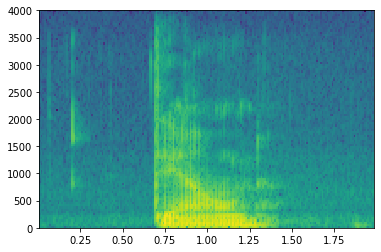

In [5]:
# Extracting training data
X=[]
Y=[]
for k in range(4):
    train_audio_path = r'C:\Users\Arshit\Speech Recog\small train\audio'+"\\"+classes[k]
    labels=os.listdir(train_audio_path)
    for i in range(len(labels)):
        x=graph_spectrogram(train_audio_path+'//'+labels[i])
        if x.shape[1]==198:
            X.append(x)
            a=np.zeros((4,))
            a[k]=1
            Y.append(a)
    print(k,end=" ")

X=np.reshape(X,(len(X),)+(101,198))
Y=np.reshape(Y,(len(Y),)+(4,))
print()
save('X_train',X)
save('Y_train',Y)
X_train=np.load("X_train.npy")
Y_train=np.load("Y_train.npy")

X_train=X_train.swapaxes(1,2)
print(X_train.shape)
print(Y_train.shape)

0 1 2 3 
(534, 198, 101)
(534, 4)


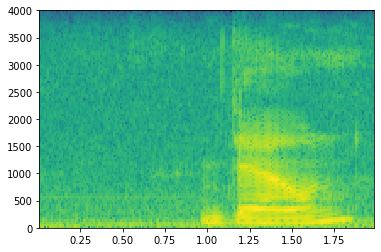

In [6]:
# Extracting testing data
X=[]
Y=[]
for k in range(4):
    test_audio_path = r'C:\Users\Arshit\Speech Recog\small test\audio'+"\\"+classes[k]
    labels=os.listdir(test_audio_path)
    for i in range(len(labels)):
        x=graph_spectrogram(test_audio_path+'//'+labels[i])
        if x.shape[1]==198:
            X.append(x)
            a=np.zeros((4,))
            a[k]=1
            Y.append(a)
    print(k,end=" ")

X=np.reshape(X,(len(X),)+(101,198))
Y=np.reshape(Y,(len(Y),)+(4,))
print()
save('X_test',X)
save('Y_test',Y)
X_test=np.load("X_test.npy")
Y_test=np.load("Y_test.npy")

X_test=X_test.swapaxes(1,2)
print(X_test.shape)
print(Y_test.shape)

In [7]:
def model():
    
    inputs = Input(shape=(198,101))
    
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)
    
    conv = GRU(units=128, return_sequences = True)(conv)                                 
    conv = Dropout(0.3)(conv)                                 
    conv = BatchNormalization()(conv)         
    
    conv = GRU(units=128, return_sequences=True)(conv)                                
    conv = Dropout(0.3)(conv)                            
    conv = BatchNormalization()(conv)                                 
    conv = Dropout(0.3)(conv)   
    
    conv = Flatten()(conv)

    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    
    conv = Dense(64, activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    
    conv = Dense(32, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    conv = Dense(16, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    conv = Dense(8, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(4, activation='softmax')(conv)

    model = Model(inputs, outputs)

    return model

In [12]:
model=model()

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 198, 101)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 186, 8)            10512     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 62, 8)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 8)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 52, 16)            1424      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 17, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 17, 16)            0   

In [14]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [15]:
model.fit(X_train,Y_train,epochs=100,batch_size=32,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1412 samples, validate on 354 samples
Epoch 1/100
1412/1412 [==============================] - 3s 2ms/step - loss: 0.6769 - accuracy: 0.6981 - val_loss: 0.5614 - val_accuracy: 0.7500
Epoch 2/100
1412/1412 [==============================] - 2s 1ms/step - loss: 0.6209 - accuracy: 0.7199 - val_loss: 0.5665 - val_accuracy: 0.7500
Epoch 3/100
1412/1412 [==============================] - 2s 2ms/step - loss: 0.6104 - accuracy: 0.7245 - val_loss: 0.5677 - val_accuracy: 0.7500
Epoch 4/100
1412/1412 [==============================] - 2s 1ms/step - loss: 0.6109 - accuracy: 0.7250 - val_loss: 0.5695 - val_accuracy: 0.7500
Epoch 5/100
1412/1412 [==============================] - 2s 1ms/step - loss: 0.5983 - accuracy: 0.7346 - val_loss: 0.5713 - val_accuracy: 0.7500
Epoch 6/100
1412/1412 [==============================] - 2s 1ms/step - loss: 0.6040 - accuracy: 0.7279 - val_loss: 0.5719 - val_accur

1412/1412 [==============================] - 2s 2ms/step - loss: 0.5691 - accuracy: 0.7420 - val_loss: 0.5786 - val_accuracy: 0.7500
Epoch 54/100
1412/1412 [==============================] - 2s 1ms/step - loss: 0.5719 - accuracy: 0.7456 - val_loss: 0.5786 - val_accuracy: 0.7500
Epoch 55/100
1412/1412 [==============================] - 3s 2ms/step - loss: 0.5670 - accuracy: 0.7454 - val_loss: 0.5787 - val_accuracy: 0.7500
Epoch 56/100
1412/1412 [==============================] - 2s 2ms/step - loss: 0.5687 - accuracy: 0.7481 - val_loss: 0.5788 - val_accuracy: 0.7500
Epoch 57/100
1412/1412 [==============================] - 3s 2ms/step - loss: 0.5708 - accuracy: 0.7458 - val_loss: 0.5788 - val_accuracy: 0.7500
Epoch 58/100
1412/1412 [==============================] - 2s 2ms/step - loss: 0.5718 - accuracy: 0.7449 - val_loss: 0.5788 - val_accuracy: 0.7500
Epoch 59/100
1412/1412 [==============================] - 2s 2ms/step - loss: 0.5750 - accuracy: 0.7443 - val_loss: 0.5788 - val_accuracy

In [16]:
loss_train, acc_train = model.evaluate(X_train,Y_train)
print("loss_train = ",loss_train)
print("acc_train = ",acc_train)

1766/1766 [==============================] - 1s 524us/step
loss_train =  0.562364613280831
acc_train =  0.75


In [17]:
loss_test, acc_test = model.evaluate(X_test,Y_test)
print("loss_test = ",loss_test)
print("acc_test = ",acc_test)

534/534 [==============================] - 0s 542us/step
loss_test =  0.5625122202916092
acc_test =  0.75


In [18]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)